# Cross validation

## I) Imports

In [1]:
from proj1_helpers import *
from custom_helpers import *
from implementations import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## II) Required functions

In [2]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [13]:
def cross_validation(x, y, flag_method, degree, lambda_=0, k_fold=5, seed=143225, gamma=0.001, max_iters=300):
    "Train the model and evaluate loss based on cross validation"
    mses_tr = []
    mses_te = []
    
    k_indices = build_k_indices(y, k_fold, seed);
    for i in range(k_fold):
        newk_index = np.delete(k_indices, i, 0)
        indices_train = newk_index.ravel()
        indices_test = k_indices[i]

        # Train data at each iteration "i" of the loop
        x_train = x[indices_train]
        y_train = y[indices_train]

        # Validate the data at each iteration "i" of the loop
        x_test = x[indices_test]
        y_test = y[indices_test]

        # Building Polynomial base with degree passed
        x_train_poly = build_poly(x_train, degree)
        x_test_poly = build_poly(x_test, degree)

        # Standardizing data
        std_training_x, a, b = standardize(x_train_poly)
        std_testing_x, c, d = standardize(x_test_poly)

        # Getting matrix tX, adding offset value, entire colum of ones[1]
        training_tx = np.c_[np.ones(len(y_train)), std_training_x]
        testing_tx = np.c_[np.ones(len(y_test)), std_testing_x]
        
        initial_w = np.zeros((testing_tx.shape[1], 1))

        if flag_method == 0:
            # Use linear regression (full gradient descent)
            weight, loss_tr = least_squares_GD(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 1:
            # Use linear regression (stochastic gradient descent)
            weight, loss_tr = least_squares_SGD(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 2:
            # Use least squares method
            weight, loss_tr = least_squares(y_train, training_tx)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 3:
            # Use ridge regression
            weight, loss_tr = ridge_regression(y_train, training_tx, lambda_)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 4:
            # Use logistic regression
            weight, loss_tr = logistic_regression_SGD(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = calculate_log_loss(y_test, testing_tx, weight)
            
        if flag_method == 5:
            # Use regularized logistic regression
            weight, loss_tr = reg_logistic_regression_SGD(y_train, training_tx, initial_w, max_iters, gamma, lambda_)
            loss_te = calculate_log_loss(y_test, testing_tx, weight)
        
        # Append loss of this round to list
        mses_tr.append(loss_tr)
        mses_te.append(loss_te)


    loss_tr = np.mean(mses_tr)
    loss_te = np.mean(mses_te)
    return loss_tr, loss_te

## III) Main
### Load the data

In [4]:
# Loading Data
print("Loading Data, please wait")
train_y, train_x, ids_train = load_csv_data('data/train.csv')
print("Data loaded, continue!!")

Loading Data, please wait
Data loaded, continue!!


In [ ]:
"""
Methods mapping
0    Linear regression (full gradient descent)
1    Linear regression (stochastic gradient descent)
2    Least squares method
3    Ridge regression
4    Logistic regression (stochastic gradient descent)
5    Regularized logistic regression (stochastic gradient descent)

"""

### Cross validation for methods without regularisation
Test polynominal expansion of different degrees

In [7]:
# Chose learnig method to use (see mapping above)
flag_method = 2;

# Define range for the polynomial expansion
degree_range = np.arange(1, 7)
train_losses = np.zeros(len(degree_range))
test_losses = np.zeros(len(degree_range))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree)
    print("For the Degree: %d , The LOSS is : %f" %(degree, loss_te))
    train_losses[ind_degree] = loss_tr
    test_losses[ind_degree] = loss_te
print("Cross Validation finished!!")
test_losses_abs = np.absolute(test_losses)
best_value = np.unravel_index(np.argmin(test_losses_abs), test_losses.shape)
print("The best degrees are: ", degree_range[best_value])

For the Degree: 1 , The LOSS is : 0.937235
For the Degree: 2 , The LOSS is : 2119.333097


KeyboardInterrupt: 

### Cross validation for Methods using regularisation
Grid search over different degrees of polynominal expansion and for different lambdas

In [26]:
# Chose learnig method to use (see mapping above)
flag_method = 3;

# Define range for the polynomial expansion and for lambda
degree_range = np.arange(1, 4)
lambda_range = np.arange(-0.01, 0.1, 0.01)
train_losses = np.zeros((len(degree_range), len(lambda_range)))
test_losses = np.zeros((len(degree_range), len(lambda_range)))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    for ind_lambda_, lambda_ in enumerate(lambda_range):
        loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_)
        print("For the Degree: %d and lambda %f, The LOSS is : %f" %(degree, lambda_, loss_te))
        train_losses[ind_degree, ind_lambda_] = loss_tr
        test_losses[ind_degree, ind_lambda_] = loss_te

print("Cross Validation finished!!")
test_losses_abs = np.absolute(test_losses)
best_value = np.unravel_index(np.argmin(test_losses_abs), test_losses.shape)
print(best_value)
print("Best degree: %d, with lambda %f " %(degree_range[best_value[0]], lambda_range[best_value[1]]))

For the Degree: 1 and lambda -0.010000, The LOSS is : 1.012508
For the Degree: 1 and lambda 0.000000, The LOSS is : 0.937235
For the Degree: 1 and lambda 0.010000, The LOSS is : 0.854796
For the Degree: 1 and lambda 0.020000, The LOSS is : 0.859239
For the Degree: 1 and lambda 0.030000, The LOSS is : 0.863302
For the Degree: 1 and lambda 0.040000, The LOSS is : 0.867026
For the Degree: 1 and lambda 0.050000, The LOSS is : 0.870440
For the Degree: 1 and lambda 0.060000, The LOSS is : 0.873568
For the Degree: 1 and lambda 0.070000, The LOSS is : 0.876437
For the Degree: 1 and lambda 0.080000, The LOSS is : 0.879074
For the Degree: 1 and lambda 0.090000, The LOSS is : 0.881502
For the Degree: 2 and lambda -0.010000, The LOSS is : 1.089423
For the Degree: 2 and lambda 0.000000, The LOSS is : 2119.333097
For the Degree: 2 and lambda 0.010000, The LOSS is : 0.915714
For the Degree: 2 and lambda 0.020000, The LOSS is : 0.920504
For the Degree: 2 and lambda 0.030000, The LOSS is : 0.923218
For

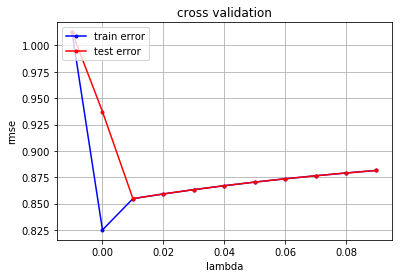

In [28]:
# Visualize
cross_validation_visualization(lambda_range, train_losses[0, :], test_losses[0, :])

In [57]:
"""
TODO: Implement plots for grid search (lambdas & poly degrees)





"""

''